In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from typing import Callable
from datetime import datetime

In [2]:
image_path = os.path.join('data', 'seg_test_hand.JPG')
path_img = image_path
img = np.array(Image.open(path_img))

In [48]:
def extract_rgb_channels(img):
    """
    Extract RGB channels from the input image.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    data_red: np.ndarray (M, N)
        Red channel of input image
    data_green: np.ndarray (M, N)
        Green channel of input image
    data_blue: np.ndarray (M, N)
        Blue channel of input image
    """

    # Get the shape of the input image
    M, N, C = np.shape(img)

    # Define default values for RGB channels
    data_red = np.zeros((M, N))
    data_green = np.zeros((M, N))
    data_blue = np.zeros((M, N))

    # ------------------
    data_red = img[:, :, 0]   
    data_green = img[:, :, 1] 
    data_blue = img[:, :, 2]  
    # ------------------
    
    return data_red, data_green, data_blue

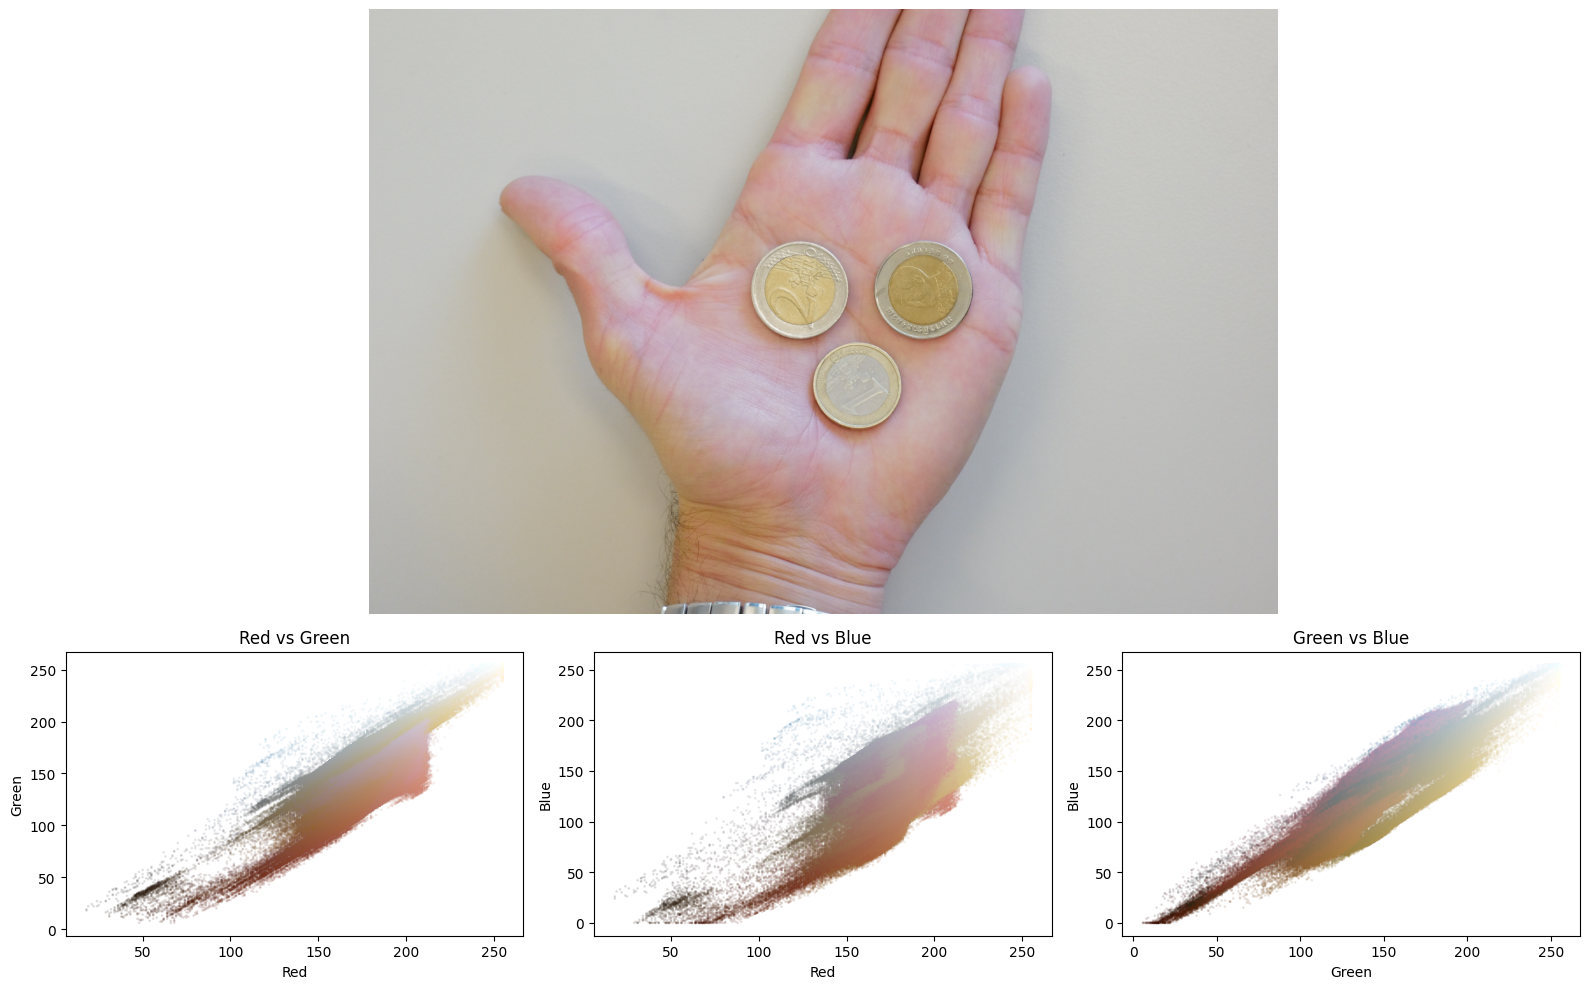

In [49]:
# Plot color space distribution 
def plot_colors_histo(
    img: np.ndarray,
    func: Callable,
    labels: list[str],
):
    """
    Plot the original image (top) as well as the channel's color distributions (bottom).

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    func: Callable
        A callable function that extracts D channels from the input image
    labels: list of str
        List of D labels indicating the name of the channel
    """

    # Extract colors
    channels = func(img=img)
    C2 = len(channels)
    M, N, C1 = img.shape
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, C2)

    # Use random seed to downsample image colors (increase run speed - 10%)
    mask = np.random.RandomState(seed=0).rand(M, N) < 0.1
    
    # Plot base image
    ax = fig.add_subplot(gs[:2, :])
    ax.imshow(img)
    # Remove axis
    ax.axis('off')
    ax1 = fig.add_subplot(gs[2, 0])
    ax2 = fig.add_subplot(gs[2, 1])
    ax3 = fig.add_subplot(gs[2, 2])

    # Plot channel distributions
    ax1.scatter(channels[0][mask].flatten(), channels[1][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax1.set_xlabel(labels[0])
    ax1.set_ylabel(labels[1])
    ax1.set_title("{} vs {}".format(labels[0], labels[1]))
    ax2.scatter(channels[0][mask].flatten(), channels[2][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax2.set_xlabel(labels[0])
    ax2.set_ylabel(labels[2])
    ax2.set_title("{} vs {}".format(labels[0], labels[2]))
    ax3.scatter(channels[1][mask].flatten(), channels[2][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax3.set_xlabel(labels[1])
    ax3.set_ylabel(labels[2])
    ax3.set_title("{} vs {}".format(labels[1], labels[2]))
        
    plt.tight_layout()


# Call plotting function with your implemented function
plot_colors_histo(
    img = img,
    func = extract_rgb_channels,
    labels = ["Red", "Green", "Blue"],
)

<Figure size 1500x1000 with 0 Axes>

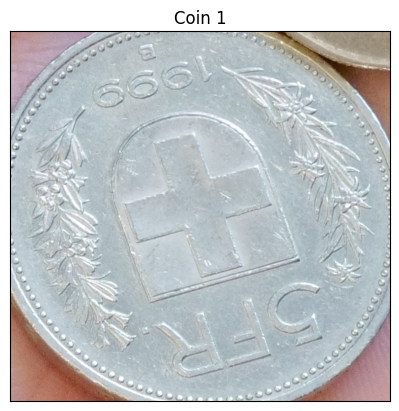

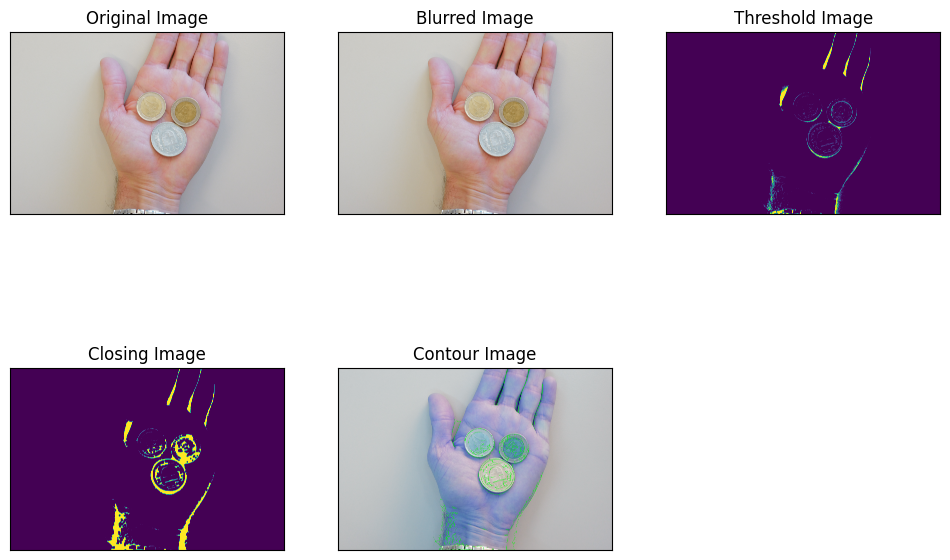

In [10]:
# wrap up
import cv2
import numpy as np

def process_image(image_path, type='neutral'):
    # 读取图片
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return
    
     # OpenCV读取为BGR格式，转换为RGB格式以适应matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 不应用高斯模糊
    blurred_image = image_rgb.copy() #cv2.GaussianBlur(image, (1, 1), 0)
    
    # RGB阈值设定: neutral bg
    lower_bound = np.array([0, 0, 0])  # 设定最低阈值
    upper_bound = np.array([150, 175, 175])  # 设定最高阈值
    if type == 'noisy':
        upper_bound = np.array([185, 180, 160])  # 设定最高阈值
    if type == 'hand':
        upper_bound = np.array([175, 175, 150])  # 设定最高阈值
    
    thresh = cv2.inRange(blurred_image, lower_bound, upper_bound)

    # 应用闭运算
    if type == 'neutral':
        kernel_1 = np.ones((25, 25), np.uint8)
        kernel_2 = np.ones((30, 30), np.uint8)
    elif type == 'noisy':
        kernel_1 = np.ones((11, 11), np.uint8)
        kernel_2 = np.ones((1, 1), np.uint8)
    elif type == 'hand':
        kernel_1 = np.ones((30, 30), np.uint8)
        kernel_2 = np.ones((35, 35), np.uint8)
    
    
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_1)
    closing = cv2.morphologyEx(closing, cv2.MORPH_CLOSE, kernel_2)

    # 计算轮廓
    contours, _ = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # 在原始图像上绘制轮廓
    contour_image = image.copy()
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 3)

    plt.figure(figsize=(15, 10))
    titles = ['Original Image', 'Blurred Image', 'Threshold Image', 'Closing Image', 'Contour Image']
    images = [image_rgb, blurred_image, thresh, closing, contour_image]

    coin_images = []
    for i, contour in enumerate(contours):
        # 计算轮廓的面积和外接圆的面积
        area = cv2.contourArea(contour)
        (x, y), radius = cv2.minEnclosingCircle(contour)
        circle_area = np.pi * (radius ** 2)

        # 检查轮廓是否接近圆形
        if abs(1 - (area / circle_area)) < 0.2:  # 调整阈值以更精确地识别圆形
            x, y, w, h = cv2.boundingRect(contour)
            coin_image = image_rgb[y:y+h, x:x+w]
            coin_images.append(coin_image)

            # 单独显示每个圆形硬币
            plt.figure()
            plt.imshow(coin_image)
            plt.title(f'Coin {len(coin_images)}')
            plt.xticks([]), plt.yticks([])

    # plot threshold image, contour image
    plt.figure(figsize=(12,8))
    for i in range(5):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.xticks([]), plt.yticks([])

    plt.show()

    return coin_images


# TODO: neutral ok; noisy ok; hand not ok
# neutral bg
# image_path = os.path.join("data", "train", "L1010310.JPG")

# noisy bg
# image_path = os.path.join("data", "train", "L1010500.JPG")

# hand bg
image_path = os.path.join("data", "train", "L1010517.JPG")
coins = process_image(image_path, type='neutral')


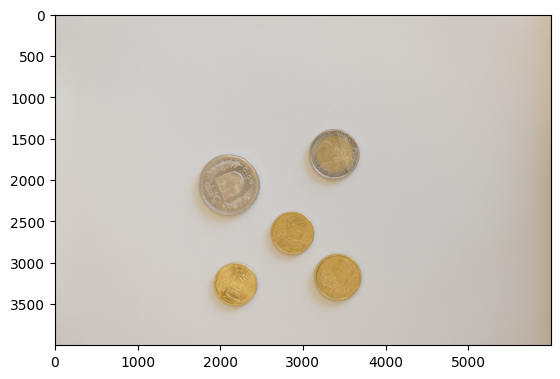

In [28]:
plt.imshow(img)

In [3]:
import torchvision.models as models
import json
import torch
import os

# 读取标签索引
with open(os.path.join('model', 'label_to_index.json'), 'r') as f:
    label_to_index = json.load(f)

# 加载预训练的 ResNet50 模型
model = models.resnet50(weights='IMAGENET1K_V2')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 修改最后一个全连接层以匹配硬币分类的类别数
num_classes = len(label_to_index)  # 假设你已经有了标签索引
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(os.path.join('model','best_model.pth')))
model = model.to(device)

In [6]:
import torchvision.transforms as transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def predict_image(image_path, model=model, transform=transform, device=device):
    
    model.eval()  # 设置模型为评估模式
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # 添加batch维度
    image = image.to(device)

    with torch.no_grad():
        output = model(image)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        top_prob, top_catid = torch.topk(probabilities, 1)

    # 反转label_to_index字典
    index_to_label = {v: k for k, v in label_to_index.items()}

    return index_to_label[top_catid.item()], top_prob.item()


Predicted class: 2CHF, Probability: 0.32290613651275635


In [ ]:
# 示例推理
test_image_path = os.path.join('data', '1.jpg')
predicted_class, probability = predict_image(test_image_path, model, transform, device)
print(f"Predicted class: {predicted_class}, Probability: {probability}")